In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA

from sklearn.metrics import classification_report

# SongOMatic
## Predicting genres from music features

### Reading and preparing the data

In [3]:
song_features = pd.read_csv("data/spotify_features/SpotifyFeatures.csv")

In [4]:
song_features.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [7]:
song_features.describe().T

,count,mean,std,min,25%,50%,75%,max
popularity,232725.0,41.127502,18.189948,0.00000,29.0000,43.000000,55.0000,100.000
acousticness,232725.0,0.368560,0.354768,0.00000,0.0376,0.232000,0.7220,0.996
danceability,232725.0,0.554364,0.185608,0.05690,0.4350,0.571000,0.6920,0.989
duration_ms,232725.0,235122.339306,118935.909299,15387.00000,182857.0000,220427.000000,265768.0000,5552917.000
energy,232725.0,0.570958,0.263456,0.00002,0.3850,0.605000,0.7870,0.999
instrumentalness,232725.0,0.148301,0.302768,0.00000,0.0000,0.000044,0.0358,0.999
liveness,232725.0,0.215009,0.198273,0.00967,0.0974,0.128000,0.2640,1.000
loudness,232725.0,-9.569885,5.998204,-52.45700,-11.7710,-7.762000,-5.5010,3.744
speechiness,232725.0,0.120765,0.185518,0.02220,0.0367,0.050100,0.1050,0.967
tempo,232725.0,117.666585,30.898907,30.37900,92.9590,115.778000,139.0540,242.903


In [215]:
song_features = song_features.drop("track_id", axis = 1)

In [11]:
song_features.groupby("genre").size()

genre
A Capella            119
Alternative         9263
Anime               8936
Blues               9023
Children's Music    5403
Children’s Music    9353
Classical           9256
Comedy              9681
Country             8664
Dance               8701
Electronic          9377
Folk                9299
Hip-Hop             9295
Indie               9543
Jazz                9441
Movie               7806
Opera               8280
Pop                 9386
R&B                 8992
Rap                 9232
Reggae              8771
Reggaeton           8927
Rock                9272
Ska                 8874
Soul                9089
Soundtrack          9646
World               9096
dtype: int64

In [216]:
song_features.genre = song_features.genre.replace({"Children’s Music": "Children's Music"})

In [15]:
song_features.groupby("genre").size().sort_values(ascending = False)

genre
Children's Music    14756
Comedy               9681
Soundtrack           9646
Indie                9543
Jazz                 9441
Pop                  9386
Electronic           9377
Folk                 9299
Hip-Hop              9295
Rock                 9272
Alternative          9263
Classical            9256
Rap                  9232
World                9096
Soul                 9089
Blues                9023
R&B                  8992
Anime                8936
Reggaeton            8927
Ska                  8874
Reggae               8771
Dance                8701
Country              8664
Opera                8280
Movie                7806
A Capella             119
dtype: int64

In [19]:
song_features = song_features.drop(song_features[song_features.genre == "A Capella"].index)

In [20]:
song_features.shape

(232606, 17)

In [23]:
song_features.groupby("artist_name").size().sort_values(ascending = False)

artist_name
Giuseppe Verdi            1394
Giacomo Puccini           1137
Kimbo Children's Music     971
Nobuo Uematsu              825
Richard Wagner             804
                          ... 
Ofra Haza                    1
Off The Meds                 1
ChrisandQueen                1
Ocho Drippin                 1
정진우                          1
Length: 14555, dtype: int64

In [33]:
num_songs_by_artist = song_features.value_counts("artist_name")
(num_songs_by_artist == 1).sum() / len(num_songs_by_artist)

0.2543455857093782

In [35]:
(num_songs_by_artist > 10).sum() / len(num_songs_by_artist)

0.31260735142562696

In [217]:
song_features_for_modelling = song_features.drop(["artist_name", "track_name"], axis = 1)

In [218]:
song_features_for_modelling

,genre,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,0,0.61100,0.389,99373,0.910,0.000000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,1,0.24600,0.590,137373,0.737,0.000000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,3,0.95200,0.663,170267,0.131,0.000000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,0,0.70300,0.240,152427,0.326,0.000000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,4,0.95000,0.331,82625,0.225,0.123000,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232720,Soul,39,0.00384,0.687,326240,0.714,0.544000,D,0.0845,-10.626,Major,0.0316,115.542,4/4,0.962
232721,Soul,38,0.03290,0.785,282447,0.683,0.000880,E,0.2370,-6.944,Minor,0.0337,113.830,4/4,0.969
232722,Soul,47,0.90100,0.517,166960,0.419,0.000000,D,0.0945,-8.282,Major,0.1480,84.135,4/4,0.813
232723,Soul,44,0.26200,0.745,222442,0.704,0.000000,A,0.3330,-7.137,Major,0.1460,100.031,4/4,0.489


In [40]:
song_features.value_counts("key")

key
C     27568
G     26375
D     24064
C#    23193
A     22662
F     20265
B     17651
E     17384
A#    15516
F#    15218
G#    15149
D#     7561
dtype: int64

In [49]:
song_features_for_modelling.value_counts("mode")

mode
Major    151657
Minor     80949
dtype: int64

In [219]:
genres = song_features_for_modelling.genre
song_attributes = song_features_for_modelling.drop("genre", axis = 1)

In [220]:
song_attributes_train, song_attributes_test, genres_train, genres_test = train_test_split(
    song_attributes, genres, stratify = genres, test_size = 25000)

In [221]:
song_attributes_train.shape

(207725, 14)

In [222]:
song_attributes_test.shape

(25000, 14)

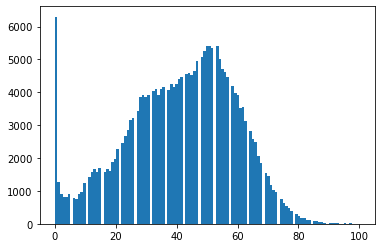

In [65]:
plt.hist(song_attributes.popularity, bins = "fd")
plt.show()

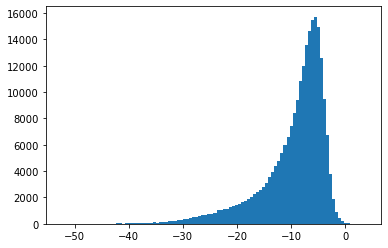

In [78]:
plt.hist(song_attributes.loudness, bins = 100)
plt.show()

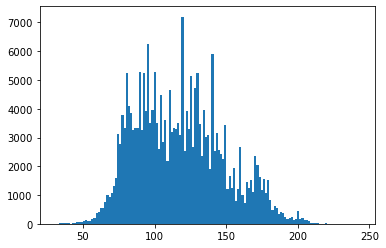

In [79]:
plt.hist(song_attributes.tempo, bins = "fd")
plt.show()

In [ ]:
# Numerical columns:
#    * MinMaxScaler (where needed)
#    * loudness: StandardScaler
# Categorical columns:
#    * OHE (pd.get_dummies)

In [86]:
MinMaxScaler().fit(song_attributes_train[["popularity", "duration_ms", "loudness"]])

,popularity,duration_ms,loudness
112078,69,207173,-2.792
158487,51,214026,-6.518
193694,54,148080,-4.350
139706,55,281173,-6.192
188801,16,303467,-6.350
...,...,...,...
92243,51,220369,-5.104
160543,44,203127,-3.780
221397,37,101107,-10.889
9830,45,201987,-8.444


In [94]:
make_column_selector(pattern = "(.*?)ness")(song_attributes_train)

['acousticness', 'instrumentalness', 'liveness', 'loudness', 'speechiness']

### Ensuring data pipelines are repeatable
TODO: Train with more / all data

In [223]:
data_transformer = make_column_transformer(
    (MinMaxScaler(), ["popularity", "duration_ms", "tempo"]),
    (StandardScaler(), ["loudness"]),
    (OneHotEncoder(drop = "first"), ["key", "mode", "time_signature"]),
    remainder = "passthrough")

In [224]:
data_transformer.fit(song_attributes_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('minmaxscaler', MinMaxScaler(),
                                 ['popularity', 'duration_ms', 'tempo']),
                                ('standardscaler', StandardScaler(),
                                 ['loudness']),
                                ('onehotencoder', OneHotEncoder(drop='first'),
                                 ['key', 'mode', 'time_signature'])])

In [225]:
NUM_RECORDS_TO_SELECT = 40000

song_attributes_transformed_train_all = data_transformer.transform(song_attributes_train)
song_attributes_transformed_train = song_attributes_transformed_train_all[:NUM_RECORDS_TO_SELECT]

genres_train_all = genres_train[:]
genres_train = genres_train[:NUM_RECORDS_TO_SELECT]

In [226]:
song_attributes_transformed_test = data_transformer.transform(song_attributes_test)

### Baseline logistic regression

In [141]:
lr = LogisticRegression().fit(song_attributes_transformed_train, genres_train)

C:\Users\Yordan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [145]:
print(classification_report(genres_train, lr.predict(song_attributes_transformed_train)))

                  precision    recall  f1-score   support

     Alternative       0.23      0.20      0.21       756
           Anime       0.38      0.32      0.35       767
           Blues       0.31      0.14      0.19       760
Children's Music       0.04      0.04      0.04      1274
       Classical       0.50      0.45      0.48       794
          Comedy       0.92      0.94      0.93       813
         Country       0.24      0.25      0.25       752
           Dance       0.18      0.14      0.16       737
      Electronic       0.44      0.48      0.46       830
            Folk       0.27      0.32      0.29       802
         Hip-Hop       0.33      0.38      0.35       826
           Indie       0.20      0.11      0.14       844
            Jazz       0.32      0.25      0.28       834
           Movie       0.42      0.42      0.42       699
           Opera       0.62      0.77      0.69       688
             Pop       0.31      0.43      0.36       806
             

In [152]:
lr_params = {
    "C": 10 ** (np.array(range(-3, 4), dtype = np.float64)),
    "fit_intercept": [True, False]
}

grid_search_lr = GridSearchCV(LogisticRegression(), lr_params, cv = 3)

In [154]:
grid_search_lr.fit(song_attributes_transformed_train, genres_train)

C:\Users\Yordan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Yordan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

C:\Users\Yordan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Yordan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'fit_intercept': [True, False]})

In [157]:
grid_search_lr.best_estimator_

LogisticRegression(C=1000.0, fit_intercept=False)

In [163]:
list(zip(grid_search_lr.cv_results_["params"], grid_search_lr.cv_results_["split0_test_score"]))

[({'C': 0.001, 'fit_intercept': True}, 0.13469326533673318),
 ({'C': 0.001, 'fit_intercept': False}, 0.13634318284085795),
 ({'C': 0.01, 'fit_intercept': True}, 0.22648867556622168),
 ({'C': 0.01, 'fit_intercept': False}, 0.2287385630718464),
 ({'C': 0.1, 'fit_intercept': True}, 0.31093445327733615),
 ({'C': 0.1, 'fit_intercept': False}, 0.3029848507574621),
 ({'C': 1.0, 'fit_intercept': True}, 0.34588270586470676),
 ({'C': 1.0, 'fit_intercept': False}, 0.3385330733463327),
 ({'C': 10.0, 'fit_intercept': True}, 0.352182390880456),
 ({'C': 10.0, 'fit_intercept': False}, 0.352032398380081),
 ({'C': 100.0, 'fit_intercept': True}, 0.3542822858857057),
 ({'C': 100.0, 'fit_intercept': False}, 0.3503824808759562),
 ({'C': 1000.0, 'fit_intercept': True}, 0.35248237588120596),
 ({'C': 1000.0, 'fit_intercept': False}, 0.3494825258737063)]

In [167]:
lr_params = {
    "C": [1e5]
}

grid_search_lr = GridSearchCV(LogisticRegression(), lr_params, cv = 3)

In [168]:
grid_search_lr.fit(song_attributes_transformed_train, genres_train)

KeyboardInterrupt: 

In [166]:
list(zip(grid_search_lr.cv_results_["params"], grid_search_lr.cv_results_["split0_test_score"]))

[({'C': 100000.0}, 0.352032398380081)]

In [169]:
lr_params = {
    "C": [1e5],
    "max_iter": [10000]
}

grid_search_lr = GridSearchCV(LogisticRegression(), lr_params, cv = 3)

In [170]:
grid_search_lr.fit(song_attributes_transformed_train, genres_train)

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [100000.0], 'max_iter': [10000]})

In [171]:
list(zip(grid_search_lr.cv_results_["params"], grid_search_lr.cv_results_["split0_test_score"]))

[({'C': 100000.0, 'max_iter': 10000}, 0.35893205339733014)]

### Second-degree feature interactions
TODO: Reuse the pipeline from above. Create two data transformation pipelines: one with, and one without quadratic features

In [227]:
polynomial_features = PolynomialFeatures(degree = 2, interaction_only = False)
polynomial_features.fit(song_attributes_transformed_train)

song_attributes_transformed_train_quad = polynomial_features.transform(song_attributes_transformed_train)
song_attributes_transformed_test_quad = polynomial_features.transform(song_attributes_transformed_test)

In [235]:
song_attributes_transformed_train_quad.shape

(40000, 406)

### Logistic regression

In [176]:
lr_params = {
    "C": [1e5],
    "max_iter": [100]
}
# TODO: Perform more extensive hyperparameter search
grid_search_lr = GridSearchCV(LogisticRegression(), lr_params, cv = 3)

In [177]:
grid_search_lr.fit(song_attributes_transformed_train_quad, genres_train)

C:\Users\Yordan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Yordan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [100000.0], 'max_iter': [100]})

In [178]:
grid_search_lr.cv_results_

{'mean_fit_time': array([3.54204814]),
 'std_fit_time': array([0.09416557]),
 'mean_score_time': array([0.01963178]),
 'std_score_time': array([0.00471623]),
 'param_C': masked_array(data=[100000.0],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_iter': masked_array(data=[100],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 100000.0, 'max_iter': 100}],
 'split0_test_score': array([0.36568172]),
 'split1_test_score': array([0.3580321]),
 'split2_test_score': array([0.36423642]),
 'mean_test_score': array([0.36265008]),
 'std_test_score': array([0.00331829]),
 'rank_test_score': array([1])}

In [179]:
print(classification_report(genres_train, grid_search_lr.best_estimator_.predict(song_attributes_transformed_train_quad)))

                  precision    recall  f1-score   support

     Alternative       0.30      0.24      0.27       756
           Anime       0.49      0.44      0.46       767
           Blues       0.35      0.34      0.35       760
Children's Music       0.34      0.27      0.30      1274
       Classical       0.59      0.53      0.56       794
          Comedy       0.96      0.93      0.95       813
         Country       0.26      0.35      0.30       752
           Dance       0.20      0.17      0.18       737
      Electronic       0.48      0.52      0.50       830
            Folk       0.31      0.34      0.32       802
         Hip-Hop       0.35      0.43      0.39       826
           Indie       0.25      0.16      0.20       844
            Jazz       0.38      0.38      0.38       834
           Movie       0.52      0.52      0.52       699
           Opera       0.67      0.78      0.72       688
             Pop       0.36      0.39      0.37       806
             

### AdaBoost (base: tree), regular data

In [186]:
ada_params = {
    # TODO: base_estimator: log regr
    "n_estimators": [5, 10, 100]
}

grid_search_ada = GridSearchCV(AdaBoostClassifier(), ada_params, cv = 3)

In [187]:
grid_search_ada.fit(song_attributes_transformed_train, genres_train)

GridSearchCV(cv=3, estimator=AdaBoostClassifier(),
             param_grid={'n_estimators': [5, 10, 100]})

In [188]:
grid_search_ada.cv_results_

{'mean_fit_time': array([0.23668981, 0.47282163, 4.59694854]),
 'std_fit_time': array([0.00964913, 0.00609991, 0.05449977]),
 'mean_score_time': array([0.03190009, 0.05716968, 0.55983671]),
 'std_score_time': array([0.00161771, 0.00095522, 0.05598204]),
 'param_n_estimators': masked_array(data=[5, 10, 100],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 5}, {'n_estimators': 10}, {'n_estimators': 100}],
 'split0_test_score': array([0.15089246, 0.15419229, 0.1579421 ]),
 'split1_test_score': array([0.15179241, 0.14699265, 0.13709315]),
 'split2_test_score': array([0.17311731, 0.15646565, 0.14821482]),
 'mean_test_score': array([0.15860073, 0.1525502 , 0.14775002]),
 'std_test_score': array([0.01027135, 0.00403788, 0.00851789]),
 'rank_test_score': array([1, 2, 3])}

In [189]:
ada_params = {
    "n_estimators": [1000]
}

grid_search_ada = GridSearchCV(AdaBoostClassifier(), ada_params, cv = 3)

In [190]:
grid_search_ada.fit(song_attributes_transformed_train, genres_train)

GridSearchCV(cv=3, estimator=AdaBoostClassifier(),
             param_grid={'n_estimators': [1000]})

In [191]:
grid_search_ada.cv_results_

{'mean_fit_time': array([45.46920951]),
 'std_fit_time': array([0.52710846]),
 'mean_score_time': array([4.96158004]),
 'std_score_time': array([0.08565848]),
 'param_n_estimators': masked_array(data=[1000],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 1000}],
 'split0_test_score': array([0.14939253]),
 'split1_test_score': array([0.13619319]),
 'split2_test_score': array([0.14821482]),
 'mean_test_score': array([0.14460018]),
 'std_test_score': array([0.00596405]),
 'rank_test_score': array([1])}

### AdaBoost (base: logistic regression)
TODO: AdaBoost on quad features

In [192]:
ada_params = {
    "base_estimator": [LogisticRegression(C = 0.1)] ,
    "n_estimators": [100, 200]
}

grid_search_ada = GridSearchCV(AdaBoostClassifier(), ada_params, cv = 3)

In [193]:
grid_search_ada.fit(song_attributes_transformed_train, genres_train)

GridSearchCV(cv=3, estimator=AdaBoostClassifier(),
             param_grid={'base_estimator': [LogisticRegression(C=0.1)],
                         'n_estimators': [100, 200]})

In [194]:
grid_search_ada.cv_results_

{'mean_fit_time': array([32.50828425, 65.20602806]),
 'std_fit_time': array([0.09569548, 1.1727081 ]),
 'mean_score_time': array([0.93149813, 1.84623059]),
 'std_score_time': array([0.01346572, 0.02354142]),
 'param_base_estimator': masked_array(data=[LogisticRegression(C=0.1), LogisticRegression(C=0.1)],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[100, 200],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'base_estimator': LogisticRegression(C=0.1), 'n_estimators': 100},
  {'base_estimator': LogisticRegression(C=0.1), 'n_estimators': 200}],
 'split0_test_score': array([0.08729564, 0.10184491]),
 'split1_test_score': array([0.09074546, 0.10634468]),
 'split2_test_score': array([0.0949595, 0.1069607]),
 'mean_test_score': array([0.0910002, 0.1050501]),
 'std_test_score': array([0.00313394, 0.00228032]),
 'rank_test_score': array([2, 1])}

### Dimensionality reduction via PCA
TODO: Integrate into third pipeline in order to estimate the order and significance of each preprocessing step

In [196]:
pca = PCA()
pca.fit(song_attributes_transformed_train)

PCA()

#### PCA: regular data

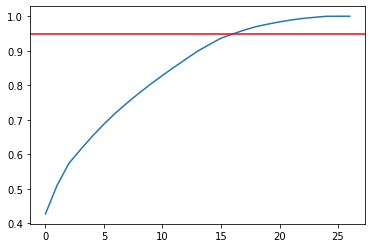

In [203]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline([0.95], c = "r")

In [237]:
pca = PCA(n_components = 0.95)
pca.fit(song_attributes_transformed_train_quad)

PCA(n_components=0.95)

#### PCA: quadratic feature interactions

In [238]:
song_attributes_transformed_train_quad_pca = pca.transform(song_attributes_transformed_train_quad)
song_attributes_transformed_test_quad_pca = pca.transform(song_attributes_transformed_test_quad)

In [239]:
song_attributes_transformed_train_quad.shape, song_attributes_transformed_train_quad_pca.shape

((40000, 406), (40000, 44))

In [242]:
lr_params = {
    "C": [1e5],
    "max_iter": [100]
}

grid_search_lr = GridSearchCV(LogisticRegression(), lr_params, cv = 3)

In [243]:
grid_search_lr.fit(song_attributes_transformed_train_quad_pca, genres_train)

C:\Users\Yordan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Yordan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [100000.0], 'max_iter': [100]})

In [244]:
grid_search_lr.cv_results_

{'mean_fit_time': array([4.54598681]),
 'std_fit_time': array([0.03933531]),
 'mean_score_time': array([0.01562524]),
 'std_score_time': array([0.00169544]),
 'param_C': masked_array(data=[100000.0],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_iter': masked_array(data=[100],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 100000.0, 'max_iter': 100}],
 'split0_test_score': array([0.35030748]),
 'split1_test_score': array([0.35475887]),
 'split2_test_score': array([0.34613365]),
 'mean_test_score': array([0.3504]),
 'std_test_score': array([0.00352184]),
 'rank_test_score': array([1])}

In [246]:
print(classification_report(genres_train, grid_search_lr.best_estimator_.predict(song_attributes_transformed_train_quad_pca)))

C:\Users\Yordan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

       A Capella       0.00      0.00      0.00        20
     Alternative       0.20      0.14      0.16      1587
           Anime       0.44      0.35      0.39      1507
           Blues       0.30      0.22      0.26      1511
Children's Music       0.14      0.15      0.15      2618
       Classical       0.50      0.49      0.49      1575
          Comedy       0.92      0.93      0.93      1681
         Country       0.25      0.26      0.26      1563
           Dance       0.16      0.14      0.15      1474
      Electronic       0.44      0.45      0.45      1625
            Folk       0.25      0.29      0.27      1609
         Hip-Hop       0.33      0.35      0.34      1510
           Indie       0.20      0.09      0.12      1605
            Jazz       0.35      0.29      0.32      1665
           Movie       0.45      0.42      0.43      1313
           Opera       0.60      0.75      0.67      1370
             

C:\Users\Yordan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yordan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# TODO: Create proper pipelines
# TODO: Extract functions to avoid code repetition

### Taking song titles into account: TF-IDF modelling
TODO: Integrate into model

In [248]:
tf_idf = TfidfVectorizer()

In [252]:
tf_idf.fit(song_features.track_name)

TfidfVectorizer()